## ReAct agent Architecture

### AIM

#### This is the intution behind ReAct , a general agent architecture.

1. `act` - let the model call specific tools
2. `observe` - pass the tool output back to the model
3. `Reason` - let the model reason about the tool output to decide what to do next(eg:- call another tool or just respond directly)

In [2]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper 

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results = 2, doc_content_chars_max = 500)
arxiv = ArxivQueryRun(api_wrapper = api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [5]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results = 2, doc_content_chars_max = 500)
wiki = WikipediaQueryRun(api_wrapper = api_wrapper_wiki)
print(wiki.name)

wikipedia


In [6]:
wiki.invoke("What us Machine Learning?" )

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [7]:
from dotenv import load_dotenv
load_dotenv()


import os 
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]  = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING_V2"]  ="true"
os.environ["LANGCHAIN_PROJECT"] = "React-Agent"

In [8]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

In [9]:
tavily.invoke("Provide me the  recent AI news May 2025")

[{'title': 'Latest AI Breakthroughs and News: April- May 2025 - Crescendo.ai',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': "Date: May 2, 2025Summary: Recent research reveals a significant uptick in the adoption of artificial intelligence across manufacturing sectors. The study indicates that AI technologies are being increasingly utilized to optimize production processes, enhance quality control, and improve supply chain management, signaling a transformative shift in industrial operations.Source: PES Media\n\nUK Music Industry Expresses Concern Over AI Training Concessions [...] The Fresh and Interesting Artificial Intelligence News\n\nHere are all the impactful and latest AI breakthroughs that are shaping the world around us.Â\n\nUS Tech Giants Face New Challenge as Alibaba's Qwen3 Narrows the AI Gap\n\nDate: May 5, 2025Summary: Alibabaâ\x80\x99s latest AI model, Qwen3, significantly narrows the technology gap with leading US firms. Qwen3's advan

In [22]:
## Custom Functions
def multiply(a:int,b:int)-> int:
    """Multiply a and b
    Args:
        a : first int
        b : second int
""" 

    return a * b


### This will be tool
def add(a:int,b:int)-> int:
    """Add a and b
    Args:
        a : first int
        b : second int
""" 

    return a + b



def divide(a:int,b:int)-> int:
    """Divide a and b
    Args:
        a : first int
        b : second int
""" 

    return a / b



## Combine all the tools in the list
tools = [arxiv,wiki,tavily,multiply,divide]

In [23]:
### Intialize my LLM Model 
from langchain_groq import ChatGroq

llm = ChatGroq(model = "qwen-qwq-32b")
llm_with_tools= llm.bind_tools(tools)

In [24]:
from pprint import pprint 
from langchain_core.messages import AIMessage,HumanMessage

llm_with_tools.invoke([HumanMessage(content = f"What is the recent AI  News")])


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eqgn', 'function': {'arguments': '{"query": "recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 214, 'prompt_tokens': 563, 'total_tokens': 777, 'completion_time': 0.53261286, 'prompt_time': 0.030167621, 'queue_time': 0.25203833800000003, 'total_time': 0.562780481}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_1e88ca32eb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c5031bdf-02df-4606-a703-c8c9708c75e8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'call_eqgn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 563, 'output_tokens': 214, 'total_tokens': 777})

In [25]:
llm_with_tools.invoke([HumanMessage(content = f"What is the recent about Cricket")]).tool_calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent cricket news'},
  'id': 'call_5edw',
  'type': 'tool_call'}]

In [26]:
## State Schma
from typing_extensions import TypedDict 
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


In [27]:
### Entire Chatbot with Langgraph
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END 
from langgraph.prebuilt import ToolNode 
from langgraph.prebuilt import tools_condition 


### Node definiation
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


In [28]:
### Build Graph
builder  = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))


## Add Edge
builder.add_edge(START,"tool_calling_llm")

builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")
# builder.add_edge("tools",END)


graph = builder.compile()

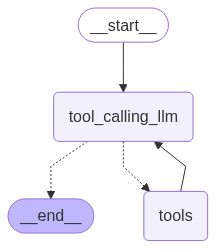

In [29]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
messages = graph.invoke({"messages": HumanMessage(content = 
""" Provide me the Top AI news from the May 2025 ,  
add 5 plus 5  and then multiply  3 and 10
""")})


### print resulst
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

 Provide me the Top AI news from the May 2025 ,  
add 5 plus 5  and then multiply  3 and 10

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_56mm)
 Call ID: call_56mm
  Args:
    query: Top AI news May 2025
  multiply (call_wkg9)
 Call ID: call_wkg9
  Args:
    a: 3
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News | Latest AI News, Analysis & Events", "url": "https://www.artificialintelligence-news.com/", "content": "[AGI](https://www.artificialintelligence-news.com/categories/agi/)\n\nMay 14, 2025\n\n# [US slams brakes on AI Diffusion Rule, hardens chip export curbs](https://www.artificialintelligence-news.com/news/us-slams-brakes-ai-diffusion-rule-hardens-chip-export-curbs/)\n\n![Saudi Arabia moves to build its own AI future with 

In [33]:
messages = graph.invoke({"messages": HumanMessage(content = "What is IPL  and what are the teams in IPL?")})


### print resulst
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is IPL  and what are the teams in IPL?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_am1g)
 Call ID: call_am1g
  Args:
    query: Indian Premier League
================================= Tool Message =================================
Name: wikipedia

Page: Indian Premier League
Summary: The Indian Premier League (IPL) is a professional Twenty20 cricket league in India organised by the Board of Control for Cricket in India (BCCI). Founded in 2007, the league features ten state-based or city-based franchise teams. The IPL is the most popular and richest cricket league in the world and is held between March and May. It has an exclusive window in the Future Tours Programme of the International Cricket Council (ICC), resulting in fewer internatio
================================== Ai Message ==================================
Tool Calls:
  ta

### Agent memeory

##### Aim
######  Let's introduce Agent with memory 

In [34]:
messages = graph.invoke({"messages": HumanMessage(content = "what us 5 Plus 8")})


### print resulst
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what us 5 Plus 8
================================== Ai Message ==================================

The result of 5 plus 8 is **13**.


In [36]:
messages = graph.invoke({"messages": HumanMessage(content = "Divide that by 5")})


### print resulst
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

The instruction says to "Divide that by 5," but it's unclear what "that" refers to. Could you please specify the number you want to divide by 5?


### 🧠 MemorySaver (LangGraph Checkpointer)
- LangGraph can automatically save graph state after each step using a checkpointer.

- This enables persistence—allowing the graph to resume from the last saved state.

- MemorySaver is a built-in, in-memory key-value store checkpointer.

- It's one of the simplest ways to add memory to a graph.

- ✅ To use it: compile the graph with a checkpointer, and memory is enabled.

### MemorySaver

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!
